# Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline
import opendatasets as od
from PIL import Image
import os

# Download the Data from Kaggle

In [7]:
od.download("https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: austinyunker
Your Kaggle Key: ········


  0%|          | 0.00/15.1M [00:00<?, ?B/s]

100%|██████████| 15.1M/15.1M [00:02<00:00, 6.53MB/s]


# Read the Data

### Read in all the MRIs with no tumors

In [2]:
no_tumor_path = 'brain-mri-images-for-brain-tumor-detection/no'
no_tumor_lst = list()
for MRI in os.listdir(no_tumor_path):
    full_path = os.path.join(no_tumor_path, MRI)
    no_tumor_lst.append(Image.open(full_path))

In [3]:
#See how many MRIs had no tumors
len(no_tumor_lst)

98

In [4]:
#Check that all files were read in
assert len(os.listdir(no_tumor_path)) == len(no_tumor_lst)

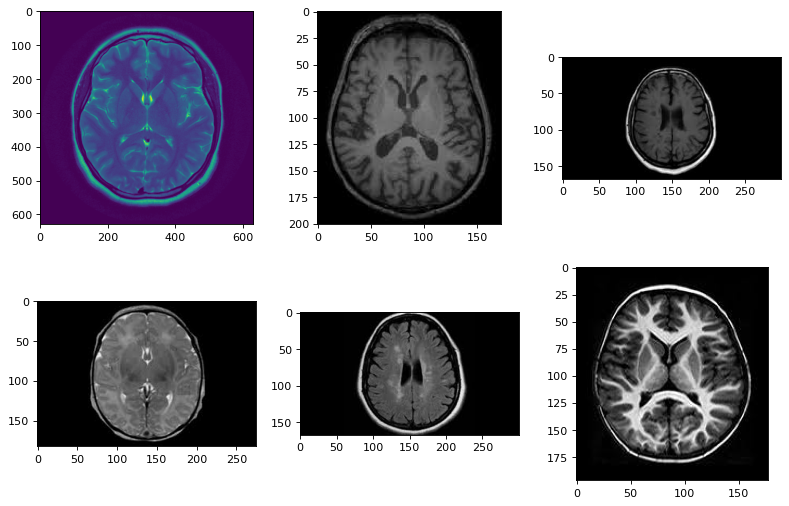

In [5]:
#View the first few MRIs without a tumor
plt.figure(figsize=(12, 12), dpi=80)
for i in range(1, 7):
    plt.subplot(3, 3, i)
    plt.imshow(no_tumor_lst[i-1])

### Read in all the MRIs with tumors

In [6]:
tumor_path = 'brain-mri-images-for-brain-tumor-detection/yes'
tumor_lst = list()
for MRI in os.listdir(tumor_path):
    full_path = os.path.join(tumor_path, MRI)
    tumor_lst.append(Image.open(full_path))

In [7]:
#See how many MRS had tumors
len(tumor_lst)

155

In [8]:
#Check that all files were read in
assert len(os.listdir(tumor_path)) == len(tumor_lst)

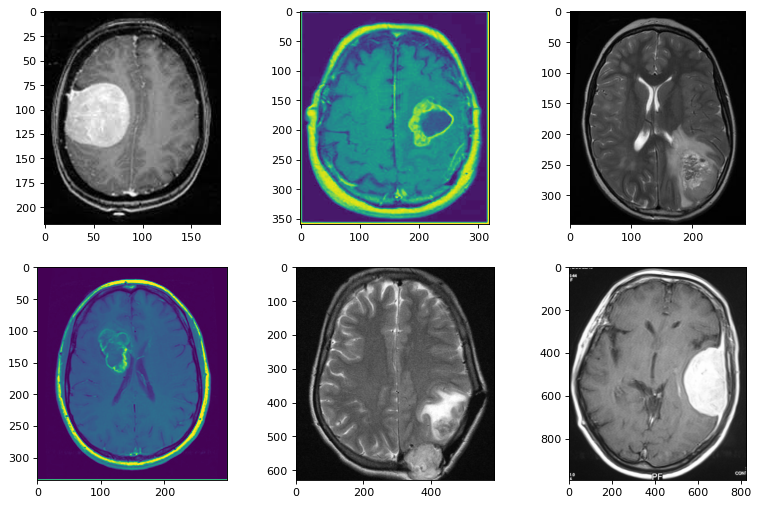

In [9]:
#View the first few MRIs with a tumor
plt.figure(figsize=(12, 12), dpi=80)
for i in range(1, 7):
    plt.subplot(3, 3, i)
    plt.imshow(tumor_lst[i-1])

In [14]:
tumors = no_tumor_lst + tumor_lst

From the images, we see that not all images have the same dimension and not all have color. 

# Prepare the Data

## Standardize MRI Dimensions

In [15]:
#Create a list containing the width of the MRIs
image_width = [image.size[0] for image in tumors]

In [16]:
#Maximum image width
np.max(image_width)

1920

In [17]:
#Minimum image width
np.min(image_width)

150

In [18]:
#Create a list containing the height of the MRIs
image_height = [image.size[1] for image in tumors]

In [19]:
#Maximum image height
np.max(image_height)

1427

In [20]:
#Minimum image height
np.min(image_height)

168

In [56]:
tumors = [MRI.resize((256, 256)) for MRI in tumors]

## Standardized MRI Colorscale

In [59]:
#Count how many picture 
num_color = 0
for MRI in tumors:
    if MRI.mode == "RGB":
        num_color += 1

In [64]:
print(f'Number of pictures with color: {num_color}')

Number of pictures with color: 0


In [93]:
tumors = [MRI.convert('L') for MRI in tumors]

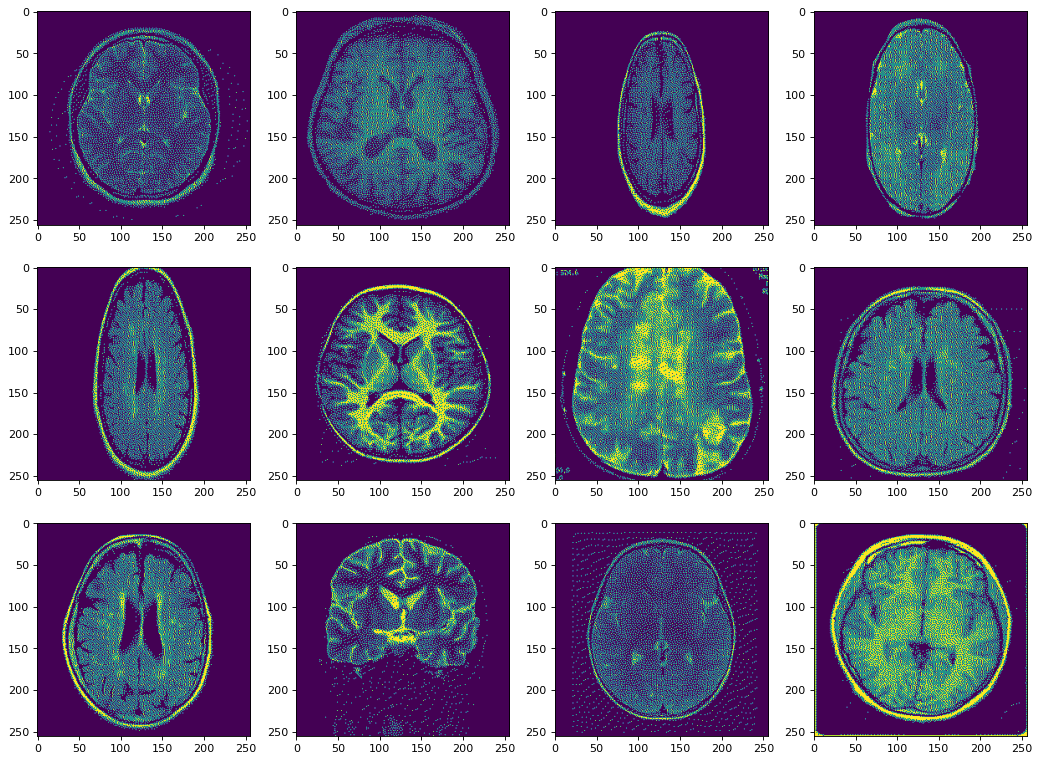

In [94]:
#View the first few MRIs with a tumor
plt.figure(figsize=(16, 12), dpi=80)
for i in range(1, 13):
    plt.subplot(3, 4, i)
    plt.imshow(tumors[i-1])

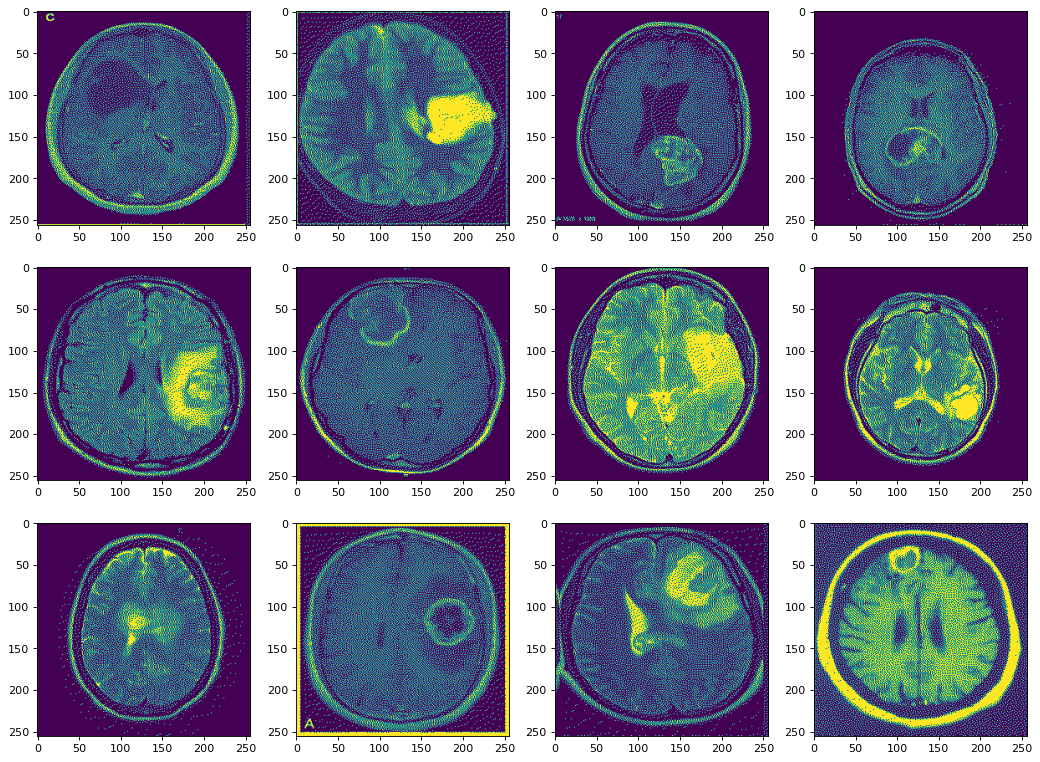

In [95]:
#View the first few MRIs with a tumor
plt.figure(figsize=(16, 12), dpi=80)
for i in range(1, 13):
    plt.subplot(3, 4, i)
    plt.imshow(tumors[-i-1])

## Pixel Normalization

In [105]:
tumor_array = np.array([np.array(MRI) for MRI in tumors])

In [106]:
tumor_array.shape

(253, 256, 256)

In [107]:
tumor_array = tumor_array.astype('float32')/255

## Create the Target

In [109]:
target = np.array([0]*len(no_tumor_lst) + [1]*len(tumor_lst))

In [110]:
target.shape

(253,)

# Create Functions to Process MRI Data

In [130]:
def load_MRI_scans(path_to_no, path_to_tumor):
    """
    This function loads the MRI images into two lists based on if they contain a tumor. 
    
    params:
        path_to_no - path to the directory containing images without tumors
        path_to_tumors - path to the directory containing images with tumors
        
    returns:
        tumors - list of images
    """
    
    no_tumor_lst = list()
    for MRI in os.listdir(path_to_no):
        full_path = os.path.join(path_to_no, MRI)
        no_tumor_lst.append(Image.open(full_path))
    
    tumor_lst = list()
    for MRI in os.listdir(path_to_tumor):
        full_path = os.path.join(path_to_tumor, MRI)
        tumor_lst.append(Image.open(full_path))
        
    tumors = no_tumor_lst + tumor_lst
    return tumors

In [117]:
def resize_MRI(lst, width, height):
    """
    This function resized the MRI images.
    
    params:
        lst - list containing the images
        width - specified width
        height - specified height
        
    returns:
        lst
    """
    lst = [MRI.resize((width, height)) for MRI in lst]
    
    return lst

In [114]:
def MRI_color_scheme(lst, color_scheme):
    """
    This function converts the MRI images to the specified color
    
    params:
        lst - list containing MRI images
        color_scheme - string containing the specified color
        
    returns:
        lst
    """
    lst = [MRI.convert(color_scheme) for MRI in lst]
    return lst

In [136]:
def pixel_normalization(lst):
    """
    This function normalizes the pixel values in the MRI images to be between 0 and 1
    
    params:
        lst - list containing MRI images
        
    returns:
        mri_array - array containing arrays of images
    """
    mri_array = np.array([np.array(MRI) for MRI in lst])
    mri_array = mri_array.astype('float32')/255
    return mri_array

In [131]:
def create_target(num_no_tumors, num_tumors):
    """
    This function creates the target array of 0s and 1s based on how many images are found to have tumors or no tumors
    
    params:
        num_no_tumors - number of non tumor images
        num_tumors - number of tumor images
        
    returns:
        target - array of 0s and 1s with length num_no_tumors + num_tumors
    """
    target = np.array([0]*num_no_tumors + [1]*num_tumors)
    return target

In [143]:
def clean_MRI_scans(path_to_no_tumors, path_to_tumors, width, height, color, num_no_tumors, num_tumors):
    """
    This function is a wrapper over various functions to clean the MRI images.
    
    params:
        path_to_no_tumors - directory path to non tumor images
        path_to_tumors - directly path to tumor images
        width - specified image width
        height - specified image height
        color - specified color scheme
        num_no_tumors - number of non tumor images
        num_tumors - number of tumor images
        
    returns:
        mri - array of image arrays
        target - array of 0s and 1s 
    
    """
    
    mri = load_MRI_scans(path_to_no_tumors, path_to_tumors)
    
    mri = resize_MRI(mri, width = width, height = height)
    
    mri = MRI_color_scheme(mri, color_scheme=color)
    mri = pixel_normalization(mri)
    
    target = create_target(num_no_tumors=num_no_tumors, num_tumors=num_tumors)
    
    return mri, target

### Test the Function

In [144]:
no_tumor_path = 'brain-mri-images-for-brain-tumor-detection/no'
tumor_path = 'brain-mri-images-for-brain-tumor-detection/yes'
width = 256
height = 256
color = 'L'
num_no_tumors = len(os.listdir(no_tumor_path))
num_tumors = len(os.listdir(tumor_path))

X, y = clean_MRI_scans(no_tumor_path, tumor_path, width, height, color, num_no_tumors, num_tumors)

In [145]:
print(X.shape)
print(y.shape)

(253, 256, 256)
(253,)
